# Soft Labeling

> How to apply soft labeling to help address noisy labels

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

This post will walk through how to do use soft labeling in fastai, and demonstrate how it helps with noisy labels to improve training and your metrics.

This post was inspired by a 1st place kaggle submission (not mine), so we know it's a good idea!  The repo for that is [here](https://github.com/alipay/cvpr2020-plant-pathology) which is done in pytorch lightning.  This post will use fastai.

Let's get started!

## Imports

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGEWOOF)
from sklearn.model_selection import StratifiedKFold
from numpy.random import default_rng

## Get Noisy Data

I am using the [noisy datasets repo](https://github.com/isaac-Flath/noisy_datasets) that was hugely inspired by the [noisy imagenette repository](https://github.com/tmabraham/noisy_imagenette) to get noisy labels for the imagewoof dataset.

First we get the noisy imagewoof csv, then use that to build the dataloaders.

In [2]:
#collapse-hide

#this code is taken from the noisy imagenette github repo linked above with slight modifications
def get_dls(size, woof, pct_noise, bs, splitter=ColSplitter()):
    path = untar_data(URLs.IMAGEWOOF)
    df = pd.read_csv('https://raw.githubusercontent.com/Isaac-Flath/noisy_datasets/main/noisy_imagewoof.csv')
    df = df.loc[df.is_valid==False]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=splitter,
                       get_x=ColReader('path', pref=path), 
                       get_y=ColReader(f'noisy_labels_{pct_noise}'),
                       item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(df, bs=bs)

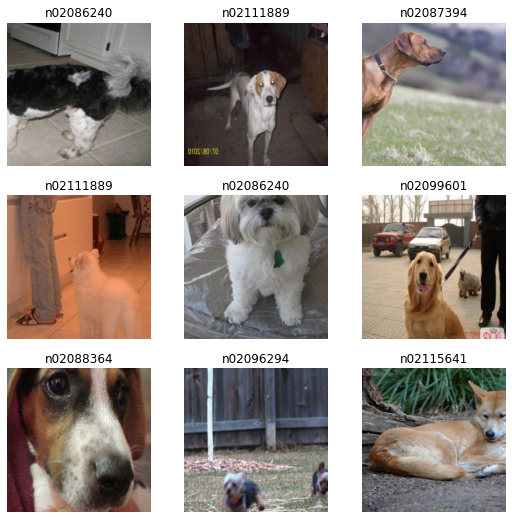

In [3]:
#collapse-hide
dls = get_dls(224,woof=True,pct_noise=5,bs=16)
dls.show_batch()

## Create Crossfold, Train, and Predict

The reason I am doing cross folds is to get predicted labels on the training set.  The predicted labels on the training set are using labels each model was not trained on.

>Note:  I am doing this with a 2 fold, but you may want to use a 5-fold or more folds.

This cross-fold code was mostly supplied by [Zach Mueller](https://twitter.com/TheZachMueller), with minor modifications by me for this dataset and tutorial.  There is also a tutorial he wrote with more details [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Cross_Validation.ipynb)

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/Isaac-Flath/noisy_datasets/main/noisy_imagewoof.csv')
train_df = df.loc[df.is_valid==False]
df.head(3)

path      truth noisy_labels_1  \
0   train/n02111889/n02111889_5826.JPEG  n02111889      n02111889   
1   train/n02111889/n02111889_1944.JPEG  n02111889      n02111889   
2  train/n02111889/n02111889_17657.JPEG  n02111889      n02111889   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02111889       n02111889       n02111889     False  
1      n02111889       n02111889       n02086240     False  
2      n02111889       n02111889       n02111889     False

In [6]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
splits, preds, targs, preds_c,  = [],[],[],[]
items = pd.DataFrame(columns = ['path', 'noisy_labels_1', 'noisy_labels_5', 'noisy_labels_25','noisy_labels_50', 'is_valid'])

for _, val_idx in skf.split(train_df.path,train_df.noisy_labels_5):
    splitter = IndexSplitter(val_idx)
    splits.append(val_idx)

    dls = get_dls(224,woof=True,pct_noise=5,bs=16,splitter=splitter)

    learn = cnn_learner(dls,resnet18,metrics=[accuracy,RocAuc()])
    learn.fine_tune(10,reset_opt=True)
    
    # store predictions
    p, t, c = learn.get_preds(ds_idx=1,with_decoded=True)
    preds.append(p); targs.append(t); preds_c.append(c); 
    items = pd.concat([items,dls.valid.items])

## Look at Predictions

Lets throw it all in a dataframe so we can look at what we have a little easier.  First, let's break out our different pieces of information.

In [7]:
imgs = L(o for o in items.path.values)
y_true = L(o for o in items.noisy_labels_5.values) # Labels from dataset
y_targ = L(dls.vocab[o] for o in torch.cat(targs)) # Labels from out predictions
y_pred = L(dls.vocab[o] for o in torch.cat(preds_c)) # predicted labels or "pseudo labels"
p_max = torch.cat(preds).max(dim=1)[0] # max model score for row

We can double check we are matching things up correctly by checking that the labels line up from the predictions and the original data.  Throwing some simple assert statements in is nice because it takes no time and it will let you know if you screw something up later as you are tinkering with things.

In [8]:
assert (y_true == y_targ) # test we matched these up correct

Put it in a dataframe and see what we have.

In [9]:
res = pd.DataFrame({'imgs':imgs,'y_true':y_true,'y_pred':y_pred}).set_index('imgs')
print(res.shape)
print(df.shape)
res.sample(5)

(9025, 2)
(12954, 7)


y_true     y_pred
imgs                                                      
train/n02086240/n02086240_6323.JPEG   n02086240  n02086240
train/n02093754/n02093754_696.JPEG    n02093754  n02093754
train/n02089973/n02089973_12157.JPEG  n02089973  n02089973
train/n02096294/n02096294_4188.JPEG   n02096294  n02096294
train/n02086240/n02086240_6595.JPEG   n02086240  n02115641

# Soft Labeling Setup

Now, we have all the data we need to train a model with soft labels.  To recap we have:

1. Dataloaders with noisy labels
1. Dataframe with img path, y_true, and y_pred (pseudo labels we generated in the cross-fold above)

Now, we will need to convert things to one-hot encoding, so let's do that for our dataframe

In [10]:
res = pd.get_dummies(res,columns=['y_true','y_pred'])

Now, lets change the Loss Function and Metric to support one hot encoded targets

In [11]:
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ.argmax(dim=axis))
    return (pred == targ).float().mean()

# Soft Labeling CallBack

Finally, lets write the callback that does the Soft Labeling.

There's a few components to this.  To put in english what is happening below in each section:

+ **before_train and before_validate:** This is grabbing the list of images for the entire dataloader.  We don't need to do this every batch, so it fits well here;
+ **before_batch:**  This filters the list of images that was defined down to only the images in our batch.  From there, it one hot encodes the y variable, and **if** it's a training batch it does y_true * 0.7 + y_pred * 0.3.  We don't want to smooth the validation set as we want a good representation of what the metrics would be on a separate test set.  This is the core of soft labeling.

The intuition for this is that the labels that the model in the crossfold got wrong above have a higher chance of just being incorrect labels.  So we smooth those out to punish incorrect classifications less.

>Note: You can set thresholds for soft labeling to smooth more or less based on the confidence your predicted labels have.  I don't have that built into this callback, but it is something you can experiment with!

This Callback a collaboration:
+ [Zach Mueller](https://twitter.com/TheZachMueller) got me started with the callback system in fastai, particularly around dataloader batch indexing in fastai
+ [Kevin H.](https://twitter.com/kevlaouach) and I collaborated on this.  We were working on this for a joint project, and we were both running experiments to get it to work right and perform. 

In [12]:
class SoftLabelCB(Callback):
    def __init__(self, df_preds,y_true_weight = 0.7): 
        '''df_preds is a pandas dataframe where index is image paths
             Must have y_true and y_pred one hot encoded columns (ie y_true_0, y_true_1)
          '''
        
        self.y_true_weight = y_true_weight
        self.y_pred_weight = 1 - y_true_weight
        self.df = df_preds

    def before_train(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.imgs_list = L(o for o in self.dl.items.iloc[:,0].values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)      
    
    def before_validate(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.imgs_list = L(o for o in self.dl.items.iloc[:,0].values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)       
    
    def before_batch(self):
        # get the images' names for the current batch
        imgs = self.imgs_list[self.dl._DataLoader__idxs[self.iter*self.dl.bs:self.iter*self.dl.bs+self.dl.bs]]
        # get soft labels
        df = self.df
        soft_labels = df.loc[imgs,df.columns.str.startswith('y_true')].values
        
        if self.training:
            soft_labels = soft_labels*self.y_true_weight + df.loc[imgs,df.columns.str.startswith('y_pred')].values*self.y_pred_weight
        self.learn.yb = (Tensor(soft_labels).cuda(),)

# Train the Model and Results

Then we put the callback and our one hot metric and loss function into a learning and fine tune it.  As you can see, we get a small bump in both accuracy and roc_auc score.

This is training on the same data that the last of the crossfolds was, so it's a good comparison. 
+ **without soft labeling:** max accuracy was 86.8%, which was hit very early on and then did not see improvements for 8 more epochs.
+ **With soft labeling:** max accuracy was 88%, over 1% higher than without soft labeling.  In addition, the last 4 epochs showed epoch over epoch improvements to the metric and loss with the last epoch being the highest accuracy.  We can almost certainly train longer to see even better benefits.

In [13]:
learn = cnn_learner(dls,resnet18,metrics=[accuracy,RocAuc()],loss_func=CrossEntropyLossOneHot(),cbs=SoftLabelCB(res))

In [14]:
learn.fine_tune(10,reset_opt=True)